# Simon's Algorithm

Given a blackbox function $f$ we seek to determine if it is one-to-one or two-to-one. 

> **One-to-One**: $f(1) \rightarrow 1$, $f(2) \rightarrow 2$, $f(3) \rightarrow 3$, $f(4) \rightarrow 4$  
> **Two-to-One**: $f(1) \rightarrow 1$, $f(2) \rightarrow 2$, $f(3) \rightarrow 1$, $f(4) \rightarrow 2$

A two-to-one mapping is defined by a hidden bitstring $b$, where

$$ \text{Given}\ x_1, x_2\ \text{if}\ f(x_1) = f(x_2) \implies x_1 \oplus x_2 = b$$

which therefore reduces the problem to finding $b$ and determining if $b=00...$ which would imply a one-to-one mapping.

## Classical Solution

To know $b$ with certainty we have to check up to $2^{n-1}+1$ possible inputs.

## Quantum Solution

<p align="center"><img src="images/simons-circuit.png"/></p>

1. Start with two $n$-qubit registers, initialised to zero:
$$ \ket{\psi_1} = \ket{0}^{\otimes n} \ket{0}^{\otimes n} $$

2. Apply a Hadamard to the first register:
$$ \ket{\psi_2} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} \ket{x} \ket{0}^{\otimes n} $$

3. Apply the query function $Q_f$ defined by $ Q_f \ket{x} \ket{a} = \ket{x} \ket{a \oplus f(x)} $:
$$ \ket{\psi_3} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} \ket{x} \ket{f(x)} $$

4. Measure the second register, f(x) can correspond to potentially two possible inputs ($x$ and $y = x \oplus b$), this means the first register becomes:
$$ \ket{\psi_4} = \frac{1}{\sqrt{2}} (\ket{x} + \ket{y}) $$

5. Apply Hadamards on the first register:
$$ \ket{\psi_5} = \frac{1}{\sqrt{2^{n+1}}} \sum_{x \in \{0,1\}^n} [(-1)^{x \cdot z} + (-1)^{y \cdot z}] \ket{z}$$

6. Measure the first register, there will only be an output if:
$$ x \cdot z = y \cdot z = (x \oplus b) \cdot z $$
$$ \implies b \cdot z = 0\ (\text{mod}\ 2) $$

By repeating this process $n$ times for $z_i$ different strings we can build the system of equations from which $b$ can be determined.

## Qiskit Implementation

In [1]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle

In [2]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

simon_circuit = simon_circuit.compose(simon_oracle(b))

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

┌───┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ H ├─░───■───────────────────────░─┤ H ├┤M├──────
     ├───┤ ░   │                       ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░───┼────■─────────■────■───░─┤ H ├─╫─┤M├───
     ├───┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └───┘ ░ ┌─┴─┐  │    │    │    │   ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤ X ├──┼────┼────┼────┼───░───────╫──╫──╫─
           ░ └───┘┌─┴─┐  │  ┌─┴─┐  │   ░       ║  ║  ║ 
q_4: ──────░──────┤ X ├──┼──┤ X ├──┼───░───────╫──╫──╫─
           ░      └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║  ║ 
q_5: ──────░───────────┤ X ├─────┤ X ├─░───────╫──╫──╫─
           ░           └───┘     └───┘ ░       ║  ║  ║ 
c: 3/══════════════════════════════════════════╩══╩══╩═
                                               0  1  2

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


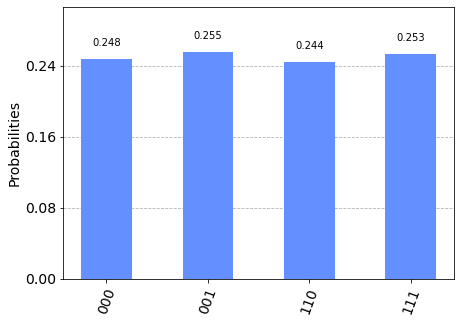

In [3]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(simon_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

In [4]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

110.001 = 0 (mod 2)
110.111 = 0 (mod 2)
110.000 = 0 (mod 2)
110.110 = 0 (mod 2)
